<a href="https://colab.research.google.com/github/Madrigalpp/MAML_with_ECG-/blob/main/ECG%E4%BF%A1%E5%8F%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb
!pip install torchinfo
import wfdb
import pywt
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
def load_data(ratio, random_seed):
    numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
                 '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
                 '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
                 '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    for n in numberSet:
        get_data_set(n, dataSet, lableSet)

    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(dataSet, lableSet, test_size=ratio, random_state=random_seed)
    return X_train, X_test, y_train, y_test
def denoise(data):
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def get_data_set(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']

    print("loading the ecg data of No." + number)

    record = wfdb.rdrecord('/content/drive/MyDrive/ecg_data/' + number, channel_names=['MLII'])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    annotation = wfdb.rdann('/content/drive/MyDrive/ecg_data/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end


    while i < j:
        try:
            lable = ecgClassSet.index(Rclass[i])
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1
    return


def load_data(ratio, random_seed):
    # numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
    #              '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
    #              '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
    #              '231', '232', '233', '234']
    numberSet = ['100']
    dataSet = []
    lableSet = []
    for n in numberSet:
        get_data_set(n, dataSet, lableSet)

    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(dataSet, lableSet, test_size=ratio, random_state=random_seed)
    return X_train, X_test, y_train, y_test


def plot_heat_map(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    # normalize
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # plot
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()


def plot_history_tf(history):
    plt.figure(figsize=(8, 8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('loss.png')
    plt.show()


def plot_history_torch(history):
    plt.figure(figsize=(8, 8))
    plt.plot(history['train_acc'])
    plt.plot(history['test_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(history['train_loss'])
    plt.plot(history['test_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('loss.png')
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = load_data(0.5,1)

In [ ]:

import torch
import torch.nn as nn
import collections
import torch.nn.functional as F
import numpy as np


class ConvBlock(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)

        return x


def ConvBlockFunction(input, w, b, w_bn, b_bn):
    x = F.conv2d(input, w, b, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True)
    x = F.relu(x)
    output = F.max_pool2d(x, kernel_size=2, stride=2)

    return output


class Classifier(nn.Module):
    def __init__(self, in_ch, n_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, n_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)

        return x

    def functional_forward(self, x, params):
        x = ConvBlockFunction(x, params[f'conv1.conv2d.weight'], params[f'conv1.conv2d.bias'],
                              params.get(f'conv1.bn.weight'), params.get(f'conv1.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv2.conv2d.weight'], params[f'conv2.conv2d.bias'],
                              params.get(f'conv2.bn.weight'), params.get(f'conv2.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv3.conv2d.weight'], params[f'conv3.conv2d.bias'],
                              params.get(f'conv3.bn.weight'), params.get(f'conv3.bn.bias'))
        x = ConvBlockFunction(x, params[f'conv4.conv2d.weight'], params[f'conv4.conv2d.bias'],
                              params.get(f'conv4.bn.weight'), params.get(f'conv4.bn.bias'))

        x = x.view(x.shape[0], -1)
        x = F.linear(x, params['logits.weight'], params['logits.bias'])

        return x


def maml_train(model, support_images, support_labels, query_images, query_labels, inner_step, args, optimizer, is_train=True):
    """
    Train the model using MAML method.
    Args:
        model: Any model
        support_images: several task support images
        support_labels: several  support labels
        query_images: several query images
        query_labels: several query labels
        inner_step: support data training step
        args: ArgumentParser
        optimizer: optimizer
        is_train: whether train

    Returns: meta loss, meta accuracy

    """
    meta_loss = []
    meta_acc = []

    for support_image, support_label, query_image, query_label in zip(support_images, support_labels, query_images, query_labels):

        fast_weights = collections.OrderedDict(model.named_parameters())
        for _ in range(inner_step):
            # Update weight
            support_logit = model.functional_forward(support_image, fast_weights)
            support_loss = nn.CrossEntropyLoss().cuda()(support_logit, support_label)
            grads = torch.autograd.grad(support_loss, fast_weights.values(), create_graph=True)
            fast_weights = collections.OrderedDict((name, param - args.inner_lr * grads)
                                                   for ((name, param), grads) in zip(fast_weights.items(), grads))

        # Use trained weight to get query loss
        query_logit = model.functional_forward(query_image, fast_weights)
        query_prediction = torch.max(query_logit, dim=1)[1]

        query_loss = nn.CrossEntropyLoss().cuda()(query_logit, query_label)
        query_acc = torch.eq(query_label, query_prediction).sum() / len(query_label)

        meta_loss.append(query_loss)
        meta_acc.append(query_acc.data.cpu().numpy())

    # Zero the gradient
    optimizer.zero_grad()
    meta_loss = torch.stack(meta_loss).mean()
    meta_acc = np.mean(meta_acc)

    if is_train:
        meta_loss.backward()
        optimizer.step()

    return meta_loss, meta_acc


In [ ]:
project_path = "./"

log_dir = project_path + "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda:0 device


In [ ]:
class ECGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        x = torch.tensor(self.x[index], dtype=torch.float32)
        y = torch.tensor(self.y[index], dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.x)


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=21, stride=1, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=23, stride=1, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=25, stride=1, padding='same')
        self.pool3 = nn.AvgPool1d(kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=27, stride=1, padding='same')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 38, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):

        x = x.reshape(-1, 1, 300)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_steps(loop, model, criterion, optimizer):
    train_loss = []
    train_acc = []
    model.train()
    for step_index, (X, y) in loop:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        train_loss.append(loss)
        pred_result = torch.argmax(pred, dim=1).detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        acc = accuracy_score(y, pred_result)
        train_acc.append(acc)
        loop.set_postfix(loss=loss, acc=acc)
    return {"loss": np.mean(train_loss),
            "acc": np.mean(train_acc)}


def test_steps(loop, model, criterion):
    test_loss = []
    test_acc = []
    model.eval()
    with torch.no_grad():
        for step_index, (X, y) in loop:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y).item()

            test_loss.append(loss)
            pred_result = torch.argmax(pred, dim=1).detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            acc = accuracy_score(y, pred_result)
            test_acc.append(acc)
            loop.set_postfix(loss=loss, acc=acc)
    return {"loss": np.mean(test_loss),
            "acc": np.mean(test_acc)}


def train_epochs(train_dataloader, test_dataloader, model, criterion, optimizer, config, writer):
    num_epochs = config['num_epochs']
    train_loss_ls = []
    train_loss_acc = []
    test_loss_ls = []
    test_loss_acc = []
    for epoch in range(num_epochs):
        train_loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        test_loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
        train_loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
        test_loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')

        train_metrix = train_steps(train_loop, model, criterion, optimizer)
        test_metrix = test_steps(test_loop, model, criterion)

        train_loss_ls.append(train_metrix['loss'])
        train_loss_acc.append(train_metrix['acc'])
        test_loss_ls.append(test_metrix['loss'])
        test_loss_acc.append(test_metrix['acc'])

        print(f'Epoch {epoch + 1}: '
              f'train loss: {train_metrix["loss"]}; '
              f'train acc: {train_metrix["acc"]}; ')
        print(f'Epoch {epoch + 1}: '
              f'test loss: {test_metrix["loss"]}; '
              f'test acc: {test_metrix["acc"]}')

        writer.add_scalar('train/loss', train_metrix['loss'], epoch)
        writer.add_scalar('train/accuracy', train_metrix['acc'], epoch)
        writer.add_scalar('validation/loss', test_metrix['loss'], epoch)
        writer.add_scalar('validation/accuracy', test_metrix['acc'], epoch)

    return {'train_loss': train_loss_ls,
            'train_acc': train_loss_acc,
            'test_loss': test_loss_ls,
            'test_acc': test_loss_acc}


loading the ecg data of No.100


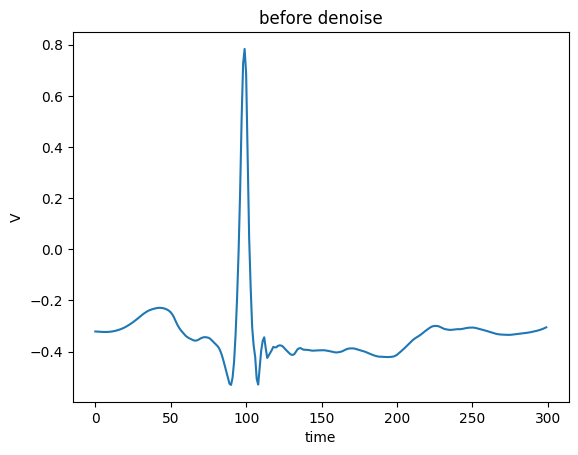

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


TypeError: ConvBlock.__init__() missing 1 required positional argument: 'out_ch'

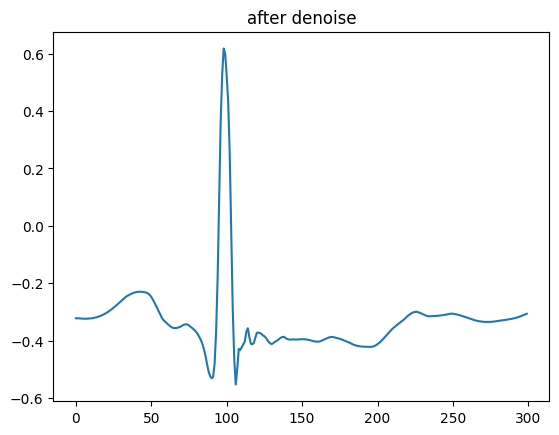

In [ ]:
config = {
    'seed': 42,  # the random seed
    'test_ratio': 0.3,  # the ratio of the test set
    'num_epochs': 30,
    'batch_size': 128,
    'lr': 0.001,
}

# X_train,y_train is the training set
# X_test,y_test is the test set
X_train, X_test, y_train, y_test = load_data(config['test_ratio'], config['seed'])
# print(X_train[0])
plt.plot(X_train[0])


plt.xlabel('time')
plt.ylabel('V')
plt.title('before denoise')
plt.show()
b = denoise(X_train[0])
plt.plot(b)
plt.title('after denoise')

Convolution = ConvBlock(X_train[0])


[-0.32166308 -0.32206713 -0.32243851 -0.32280729 -0.32313898 -0.3234321
 -0.32361455 -0.32361828 -0.32345317 -0.32308342 -0.3225163  -0.32176047
 -0.32075679 -0.31947746 -0.31797982 -0.31628769 -0.31437839 -0.31226589
 -0.30987884 -0.30715985 -0.3041398  -0.30080094 -0.29721415 -0.29344588
 -0.28946153 -0.28528396 -0.28088833 -0.27624527 -0.27140478 -0.2663803
 -0.26141194 -0.25670411 -0.25225684 -0.24820213 -0.24450082 -0.2411271
 -0.23828519 -0.23606857 -0.23419855 -0.23252906 -0.23113858 -0.22993568
 -0.22919655 -0.22914022 -0.22959275 -0.23059282 -0.23222436 -0.23448878
 -0.23748698 -0.24129889 -0.24673507 -0.25446305 -0.26454549 -0.27745492
 -0.29046595 -0.30151371 -0.31135247 -0.31897059 -0.3258021  -0.33313363
 -0.33913761 -0.34357091 -0.34733631 -0.35048612 -0.35322344 -0.35598487
 -0.35752038 -0.35705564 -0.35518255 -0.35167336 -0.3480575  -0.34570494
 -0.34412633 -0.34391317 -0.34473806 -0.3462025  -0.34940279 -0.35474556
 -0.36074866 -0.36666624 -0.37277447 -0.37853575 -0.38

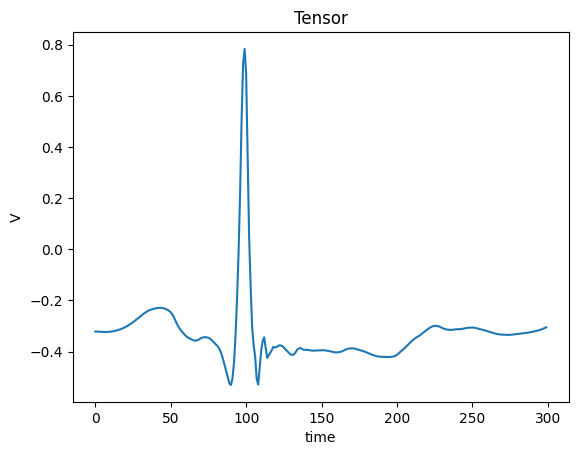

False


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# 绘制张量的图像
plt.plot(X_train[0])
print(X_train[0])

plt.xlabel('time')
plt.ylabel('V')
plt.title('Tensor')
plt.show()
print(np.all(y_train==0))

In [ ]:
def main():
    config = {
        'seed': 42,  # the random seed
        'test_ratio': 0.3,  # the ratio of the test set
        'num_epochs': 30,
        'batch_size': 128,
        'lr': 0.001,
    }

    # X_train,y_train is the training set
    # X_test,y_test is the test set
    X_train, X_test, y_train, y_test = load_data(config['test_ratio'], config['seed'])
    train_dataset, test_dataset = ECGDataset(X_train, y_train), ECGDataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # define the model
    model = Model()
    if os.path.exists(model_path):
        # import the pre-trained model if it exists
        print('Import the pre-trained model, skip the training process')
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        # build the CNN model
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

        # print the model structure
        summary(model, (config['batch_size'], X_train.shape[1]), col_names=["input_size", "kernel_size", "output_size"],
                verbose=2)

        # define the Tensorboard SummaryWriter
        writer = SummaryWriter(log_dir=log_dir)
        # train and evaluate model
        history = train_epochs(train_dataloader, test_dataloader, model, criterion, optimizer, config, writer)
        writer.close()
        # save the model
        torch.save(model.state_dict(), model_path)
        # plot the training history
        plot_history_torch(history)

    # predict the class of test data
    y_pred = []
    model.eval()
    with torch.no_grad():
        for step_index, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_result = torch.argmax(pred, dim=1).detach().cpu().numpy()
            y_pred.extend(pred_result)
    # plot confusion matrix heat map
    plot_heat_map(y_test, y_pred)


In [ ]:
if __name__ == '__main__':
    main()